목적 : 블리자드의 주식 시세 예측

In [1]:
# 데이터 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

dataset_filepath = '/content/drive/MyDrive/AIFFEL/[E-04]/data_sets/Activision Blizzard.csv'
df = pd.read_csv(dataset_filepath) 
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-07-26,91.029999,91.400002,89.989998,90.139999,89.607368,4587400
1,2021-07-27,89.940002,89.940002,81.559998,84.050003,83.553352,23141100
2,2021-07-28,84.889999,87.300003,84.720001,84.820000,84.318802,13160400
3,2021-07-29,84.870003,85.220001,83.500000,83.570000,83.076187,10839500
4,2021-07-30,83.150002,84.650002,82.849998,83.620003,83.125893,7055900


In [2]:
#시계열 데이터 준비
# Time Series 생성

df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2021-07-26    90.139999
2021-07-27    84.050003
2021-07-28    84.820000
2021-07-29    83.570000
2021-07-30    83.620003
Name: Close, dtype: float64

In [3]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

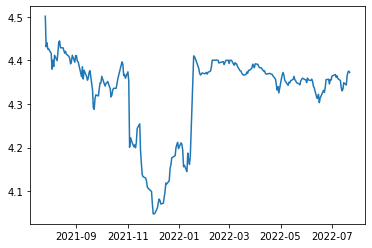

In [4]:
# 로그 변환
ts_log = np.log(ts)
plt.plot(ts_log)

In [5]:
# 일정 시간 내 구간 통계치(Rolling Statistics)를 시각화해 보는 함수
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
print('슝=3')

슝=3


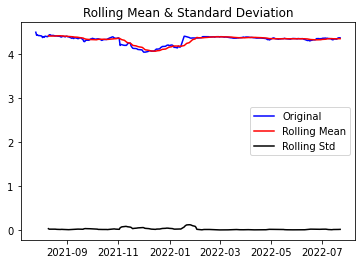

In [6]:
# 시각화 확인
plot_rolling_statistics(ts_log, window=12)

In [7]:
# Augmented Dickey-Fuller Test(ADF Test) 를 사용해 시계열 데이터의 안정성(stationary)을 테스트
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
print('슝=3')

슝=3


In [8]:
# 안정성 확인
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -2.248723
p-value                          0.189039
#Lags Used                       0.000000
Number of Observations Used    250.000000
Critical Value (1%)             -3.456781
Critical Value (5%)             -2.873172
Critical Value (10%)            -2.572969
dtype: float64


In [9]:
# 전과 같은 에러가 없도록 미리 업데이트
!pip install --upgrade statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


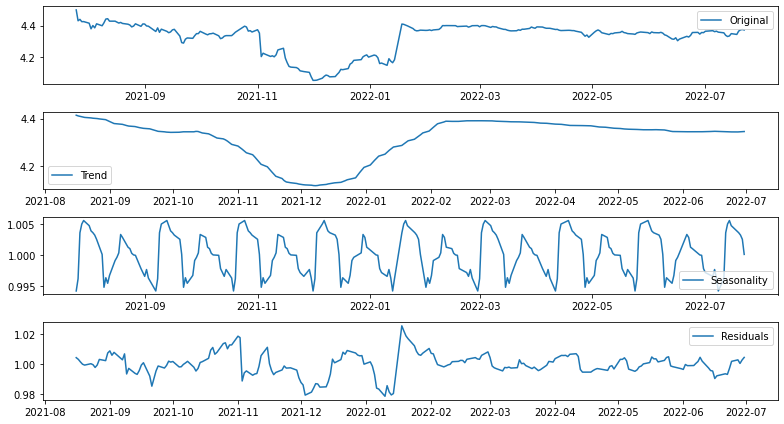

In [10]:
# 시계열 분해
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30)

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [11]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.336841
p-value                          0.000005
#Lags Used                       1.000000
Number of Observations Used    219.000000
Critical Value (1%)             -3.460567
Critical Value (5%)             -2.874830
Critical Value (10%)            -2.573853
dtype: float64


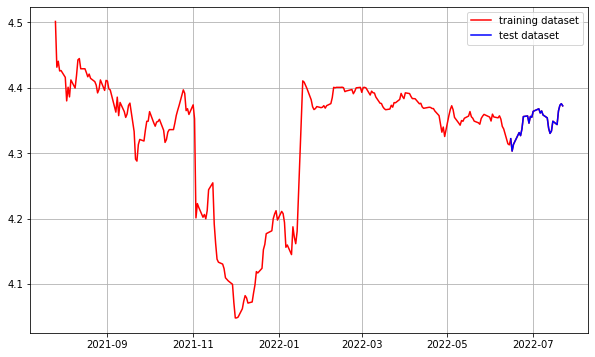

In [12]:
# 학습, 테스트 데이터셋 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


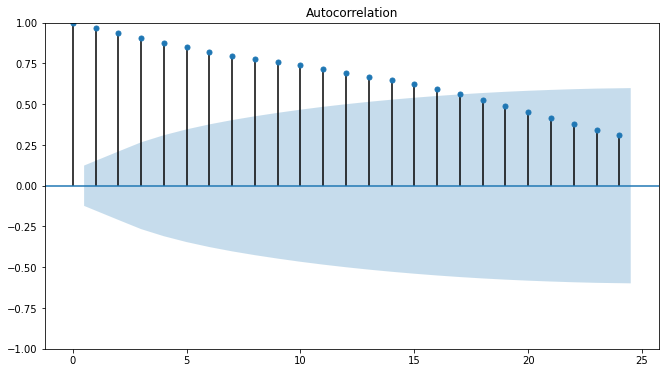

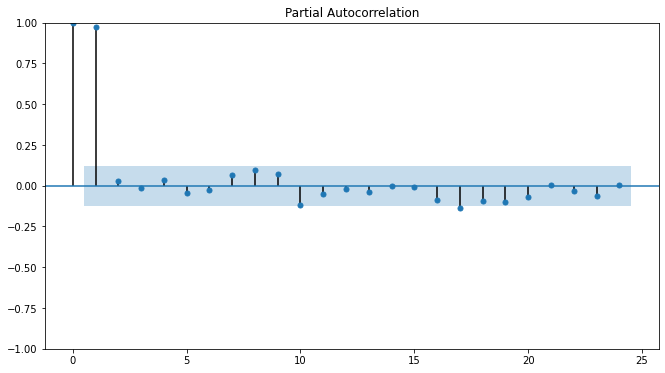

In [13]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

p = 16, 17

q = 1

Results of Dickey-Fuller Test:
Test Statistic                -1.527383e+01
p-value                        4.677417e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.490000e+02
Critical Value (1%)           -3.456888e+00
Critical Value (5%)           -2.873219e+00
Critical Value (10%)          -2.572994e+00
dtype: float64


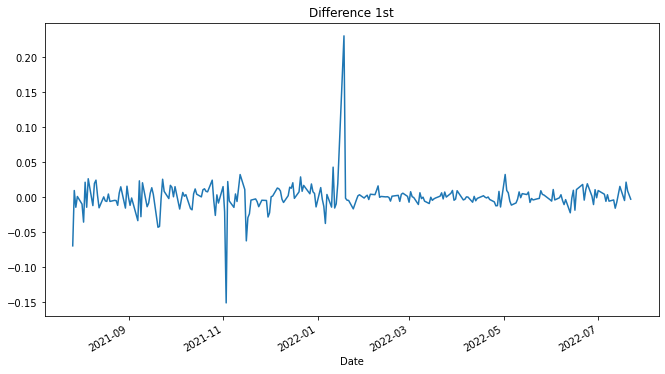

In [14]:
# 차분 안정성 확인 -> d 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -7.732347e+00
p-value                        1.116724e-11
#Lags Used                     1.500000e+01
Number of Observations Used    2.330000e+02
Critical Value (1%)           -3.458731e+00
Critical Value (5%)           -2.874026e+00
Critical Value (10%)          -2.573424e+00
dtype: float64


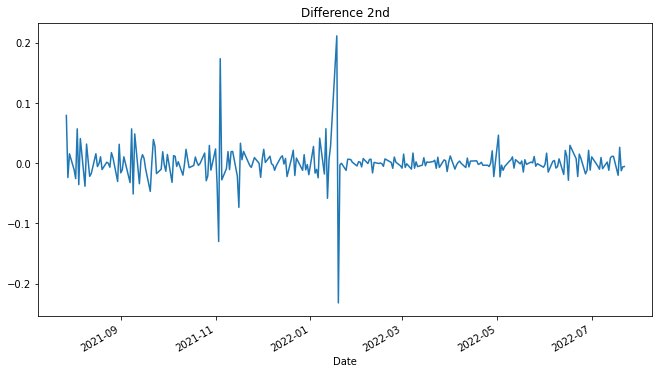

In [15]:
# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

d = 1, 2

In [16]:
# ARIMA 모델 빌드와 훈련
from statsmodels.tsa.arima.model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(16, 1, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                ARIMA(16, 1, 1)   Log Likelihood                 531.660
Date:                Wed, 27 Jul 2022   AIC                          -1027.320
Time:                        13:30:34   BIC                           -965.910
Sample:                             0   HQIC                         -1002.532
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0813      1.358      0.060      0.952      -2.580       2.742
ar.L2          0.0058      0.129      0.045      0.964      -0.247       0.259
ar.L3         -0.0372      0.111     -0.336      0.7

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


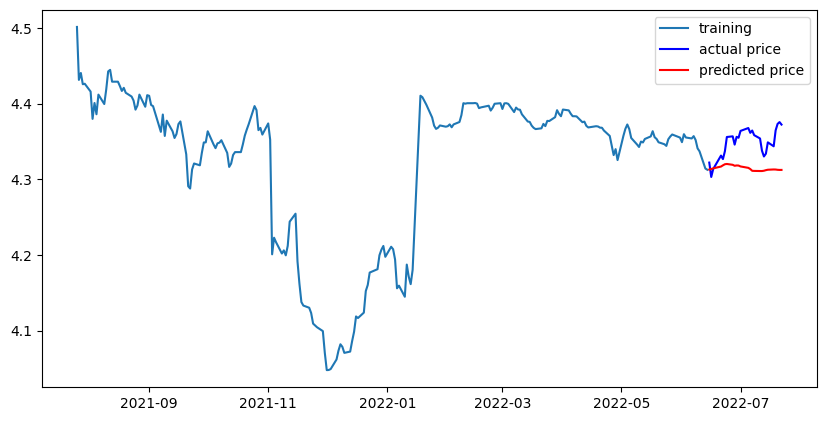

In [17]:
# 모델 테스트 및 플로팅
## Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

## Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

## Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [18]:
# 최종 예측 모델 정확도 측정(MAPE)
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  8.771986904922434
MAE:  2.635052498722998
RMSE:  2.9617540250538084
MAPE: 3.38%


- 진행 과정
  - TESLA 데이터와 동일하게 진행
  - p, q, d 값 = (16, 1, 1), (16, 1, 2), (17, 1, 1), (17, 1, 2)
  - (16, 1, 1) = 3.38%
  - (16, 1, 2) = 3.55%
  - (17, 1, 1) = 3.55%
  - (17, 1, 2) = 3.53%
  - (16, 1, 1)이 MAPE 3.38%로 가장 낮음.
  


- 회고
  - '일반적'으론 p, q 값 중 하나만 쓰고 남은 하나는 0으로 둔다는데 그 기준을 모르겠음.